# Assignment 2: Analysis on Simulacrum data

## 1. Introduction

### About Simulacrum

The Simulacrum imitates some of the data held securely by the Public Health England’s National Cancer Registration and Analysis Service. The Simulacrum has 8 tabular datasets, which contain data on 1,322,100 synthetic patients and 1,402,817 synthetic tumours. It also involves data about Systemic Anti-Cancer Therapy (SACT).

### About this report

This report mainly focuses on the first two datasets in Simulacrum, 'SIM_AV_PATIENT' and 'SIM_AV_TUMOUR.' The two tables consist of the patient and tumour registration data and are connected by patients' ID numbers.
Analysis and explorations in this report involve the following subjects:
- Patient demographic information
- Patient death causes
- Classification of neoplasms
- Associations between death rates between different groups of factors
- ...

## 2. Data Processing and Analysis

### 2.1 Basic Configurations

In [81]:
# Import necessary modules for data analysis and visualisation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import re

In [82]:
# Seaborn Configuration
sns.set(style='whitegrid',palette='muted',color_codes=True)

### 2.2 Import Data

Two CSV files are required for this report:

- sim_av_patient.csv
- sim_av_tumour.csv

 The `SIM_AV_PATIENT` table holds the demographic and clinical information and of the patient. The `SIM_AV_TUMOUR` table contains most of the detailed information regarding staging and pathology of the tumour. The two tables are connected by `PATIENTID`, an overlapped column in both tables.

In [83]:
# Patient registration data
patient = pd.read_csv('./data/sim_av_patient.csv', delimiter=',')

# Tumour registration data
tumour = pd.read_csv('./data/sim_av_tumour.csv', delimiter=',')

Another two CSV files are also required:

- icd_codes.csv
- icd_codes_3char.csv

These files contain 4-digit and 3-digit **ICD-10 codes** and descriptions, namely the 10th revision of the International Statistical Classification of Diseases and Related Health Problems. ICD-10 codes are for diseases, signs and symptoms, abnormal findings, complaints, social circumstances, and external causes of injury or diseases. ICD-10 codes are helpful to classify types of neoplasms and death causes.

In [84]:
# ICD-10 codes and descriptions
icd_codes = pd.read_csv('icd_codes.csv', delimiter=",", header=None, names=['Category Code', 'Diagnosis Code', 'Full Code', 'Abbreviated Description', 'Full Description', 'Category Title'])

# 3-digit ICD-10 codes and descriptions
icd_codes_3char = pd.read_csv('icd_codes_3char.csv', delimiter=",", header=None, names=['Code', 'Description'])

### 2.3 Data Description

#### SIM_AV_PATIENT

In [85]:
# Display the first 5 entries
patient.head()

,PATIENTID,SEX,LINKNUMBER,ETHNICITY,DEATHCAUSECODE_1A,DEATHCAUSECODE_1B,DEATHCAUSECODE_1C,DEATHCAUSECODE_2,DEATHCAUSECODE_UNDERLYING,DEATHLOCATIONCODE,NEWVITALSTATUS,VITALSTATUSDATE
0,10000001,2,810000001,A,NaN,NaN,NaN,NaN,NaN,NaN,A,2017-01-17
1,10000002,2,810000002,Z,NaN,NaN,NaN,NaN,NaN,NaN,A,2017-01-14
2,10000003,1,810000003,A,NaN,NaN,NaN,NaN,NaN,NaN,A,2017-01-17
3,10000004,1,810000004,A,NaN,NaN,NaN,NaN,NaN,NaN,A,2017-01-13
4,10000005,2,810000005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A,2017-01-16


`SIM_AV_PATIENT` includes demographic information and vital status of synthetic patients. This table has 1,322,100 entries and 12 columns. The columns are:

- **Patient ID**: ID numbers of patients, which allow linkeage to tumour registration data.
- **Sex**: Sex of patients, 1 for Male and 2 for Female.
- **Link Number**: Numbers allow linkeage to SACT data.
- **Ethnicity**: Ethnic information of patients in [NHS ethnic category code](https://www.datadictionary.nhs.uk/data_dictionary/attributes/e/end/ethnic_category_code_de.asp)
- **Death Cause Code**: Causes of death of each patient in 5 columns, coded with 1A, 1B, 1C, 2 and Underlying. The death causes are coded in ICD-10 standard.
- **Death Location Code**: Code of the location where the patient died.
- **Vital Status**: Whether the patient is alive or deceased.
- **Vital Status Date**: Date of the vital status of the patient.

You can find more information about columns in this table with [CAS Explorer](https://www.cancerdata.nhs.uk/explorer/cas_columns).


In [86]:
# Display information about the dataset
patient.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1322100 entries, 0 to 1322099
Data columns (total 12 columns):
PATIENTID                    1322100 non-null int64
SEX                          1322100 non-null int64
LINKNUMBER                   1322100 non-null int64
ETHNICITY                    1192249 non-null object
DEATHCAUSECODE_1A            330280 non-null object
DEATHCAUSECODE_1B            98085 non-null object
DEATHCAUSECODE_1C            18106 non-null object
DEATHCAUSECODE_2             141982 non-null object
DEATHCAUSECODE_UNDERLYING    327910 non-null object
DEATHLOCATIONCODE            330381 non-null object
NEWVITALSTATUS               1322100 non-null object
VITALSTATUSDATE              1322100 non-null object
dtypes: int64(3), object(9)
memory usage: 121.0+ MB


The columns in this dataset have a lot of blank values except the first three and last two.

#### SIM_AV_TUMOUR

In [87]:
# Display the first 5 entries
tumour.head()

,TUMOURID,PATIENTID,DIAGNOSISDATEBEST,SITE_ICD10_O2,SITE_ICD10_O2_3CHAR,MORPH_ICD10_O2,BEHAVIOUR_ICD10_O2,T_BEST,N_BEST,M_BEST,...,PERFORMANCESTATUS,CNS,ACE27,GLEASON_PRIMARY,GLEASON_SECONDARY,GLEASON_TERTIARY,GLEASON_COMBINED,DATE_FIRST_SURGERY,LATERALITY,QUINTILE_2015
0,10000001,10000001,2015-11-06,C443,C44,8090,3,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-11-06,L,3
1,10000002,10000002,2015-10-06,C449,C44,8090,3,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-10-06,8,2
2,10000003,10000003,2013-01-30,C449,C44,8090,3,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8,1 - least deprived
3,10000004,10000004,2015-09-15,C449,C44,8090,3,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8,2
4,10000005,10000005,2014-11-01,C449,C44,8090,3,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014-11-01,8,2


`SIM_AV_TUMOUR` holds pathological clinical information of the tumours and data of patients who were suffering from the tumours. This table has 1,402,817 entries and 34 columns.
- **ID Numbers**
- **Site**
- **Morphology**
- **Behaviour**
- **Staging in TNM System**
- **Gleason score**
- ...

In [88]:
# Display information about the dataset
tumour.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1402817 entries, 0 to 1402816
Data columns (total 34 columns):
TUMOURID                    1402817 non-null int64
PATIENTID                   1402817 non-null int64
DIAGNOSISDATEBEST           1402817 non-null object
SITE_ICD10_O2               1402303 non-null object
SITE_ICD10_O2_3CHAR         1402356 non-null object
MORPH_ICD10_O2              1402304 non-null object
BEHAVIOUR_ICD10_O2          1402410 non-null object
T_BEST                      653053 non-null object
N_BEST                      546397 non-null object
M_BEST                      535682 non-null object
STAGE_BEST                  1402801 non-null object
STAGE_BEST_SYSTEM           671840 non-null float64
GRADE                       1340030 non-null object
AGE                         1402817 non-null int64
SEX                         1402817 non-null int64
CREG_CODE                   1402817 non-null object
LINKNUMBER                  1402817 non-null int64
SCREENINGST

### 2.4 Data Cleaning

#### SIM_AV_PATIENT

Problems of the dataset are mainly involved with format, including **inconsistent delimiters**, **date format** and **data type** (blank values which are shown as NaN).

In [89]:
# patient.fillna('', inplace=True)
patient.head()

,PATIENTID,SEX,LINKNUMBER,ETHNICITY,DEATHCAUSECODE_1A,DEATHCAUSECODE_1B,DEATHCAUSECODE_1C,DEATHCAUSECODE_2,DEATHCAUSECODE_UNDERLYING,DEATHLOCATIONCODE,NEWVITALSTATUS,VITALSTATUSDATE
0,10000001,2,810000001,A,NaN,NaN,NaN,NaN,NaN,NaN,A,2017-01-17
1,10000002,2,810000002,Z,NaN,NaN,NaN,NaN,NaN,NaN,A,2017-01-14
2,10000003,1,810000003,A,NaN,NaN,NaN,NaN,NaN,NaN,A,2017-01-17
3,10000004,1,810000004,A,NaN,NaN,NaN,NaN,NaN,NaN,A,2017-01-13
4,10000005,2,810000005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A,2017-01-16


##### I. Inconsistent delimiters in death cause code columns

There are several columns in this table which represent death causes of the patients. These death causes are recorded with ICD-10 codes and if a patient died because of multiple factors, the codes are separated by commas.

However, in some of the rows, the delimiter is space(' '), semicolon(';'), or full-stop('.') rather than comma, which should be fixed.

In [90]:
# Define a function which is used to turn all other delimiters in death cause code columns with commas.
def to_comma(code):
    """
    This function replaces all the delimiters in the given code to commas.
    :param group: string
    :return: string
    """
    if type(code) == str and code != '':
        if code.count('.') > 0 and any(x.isdigit() for x in code): # Replace full-stops with commas.
            code = code.replace('.', ',')
            return code
        elif code.count(';') > 0 and any(x.isdigit() for x in code):  # Replace semicolons with commas.
            code = code.replace(';', ',')
            return code
        elif code.count(' ') > 0 and any(x.isdigit() for x in code):   # Replace space with commas.
            code = code.replace(' ', ',')
            return code
        else:
            return code
    else:
        return code
    
# Apply the function to all the death cause code columns with `Series.map()`.
patient['DEATHCAUSECODE_1A'] = patient['DEATHCAUSECODE_1A'].map(to_comma)
patient['DEATHCAUSECODE_1B'] = patient['DEATHCAUSECODE_1B'].map(to_comma)
patient['DEATHCAUSECODE_1C'] = patient['DEATHCAUSECODE_1C'].map(to_comma)
patient['DEATHCAUSECODE_2'] = patient['DEATHCAUSECODE_2'].map(to_comma)
patient['DEATHCAUSECODE_UNDERLYING'] = patient['DEATHCAUSECODE_UNDERLYING'].map(to_comma)

After converting the inconsistent delimiters, all the values should match ICD-10 codes, which means the strings or their substrings splited by commas should start with a letter (A-Y) and contain at least 2 digits. The following codes conduct the cleaning by matching ICD-10 codes with regular expression.

In [91]:
death_causes = {} # Init a dict to store all the death cause codes and how many times.

# Define a function to split multiple codes and calculate the numbers of each code.
def calculate_death_causes(code):
    if type(code) == str:
        for i in code.split(','):
            if i.strip() not in death_causes and i != '':
                death_causes[i.strip()] = 1  # If the death code is not in the dict, put it in and set its number to 1.
            elif i != '':
                death_causes[i.strip()] += 1 # Otherwise, add 1 to its number.
    else:
        pass

# Apply this function to all the death cause code columns.
patient['DEATHCAUSECODE_1A'].map(calculate_death_causes)
patient['DEATHCAUSECODE_1B'].map(calculate_death_causes)
patient['DEATHCAUSECODE_1C'].map(calculate_death_causes)
patient['DEATHCAUSECODE_2'].map(calculate_death_causes)
patient['DEATHCAUSECODE_UNDERLYING'].map(calculate_death_causes)

# Turn the dict into a Pandas Series Object.
death_causes_series = pd.Series(death_causes)

Also, some descriptive phrases mixed with standardised ICD-10 codes in this column. 

There were many problems with these phrases and thus they are to be cleaned. For example:

- **Inconsistent**: same causes but in different ways of recording: 'ISCHAEMIC HEART DISEASE' and 'Ischaemic Heart Disease'.
- **Words lost**: like 'ASPIRATION', which can be 'ASPIRATION PNEUMONIA'.
- **Ambiguous**: like 'CANCER OF LUNG' and 'PNEUMONIA'.
- **Not listed in ICD-10**: like 'CEREBROVASCULAR ACCIDENT'


In [92]:
dc_not_coded = death_causes_series[np.where(death_causes_series.index.map(len) >= 5)[0]]
dc_not_coded.index

Index(['ISCHAEMIC HEART DISEASE', 'BRONCHOPNEUMONIA',
       'CEREBROVASCULAR ACCIDENT', 'DEEP VEIN THROMBOSIS',
       'ACUTE CARDIAC FAILURE', 'RESPIRATORY FAILURE',
       'CARDIORESPIRATORY FAILURE', 'PNEUMONIA', 'CARCINOMATOSIS',
       'CORONARY ATHEROSCLEROSIS', 'ISCHAEMIC STROKE',
       'BILATEARL PULMONARY EMBOLISM', 'ASPIRATION PNEUMONIA',
       'COMPLETELY DISABLED', 'CANCER OF LUNG', 'ISCHAEMIC HEART DISEASE.',
       'CORONARY ARTERY ATHEROSCLEROSIS', 'HODGKINS LYMPHOMA',
       'ACUTE KIDNEY INJURY', 'CHRONIC KIDNEY DISEASE',
       'CONGESTIVE CARDIAC FAILURE', 'HYPERTENSION', 'Ischaemic', 'Heart',
       'Disease', 'DEMENTIA', 'ASPIRATION'],
      dtype='object')

In [93]:
# This is to check if any entry in a death cause code column contains death causes not listed in the ICD-10 code.
# It returns a list which cosist of True(for not listed) and False.

def check_dc_not_coded(values):
    arr = []
    for value in values:
        if type(value) == str:
            if any(i.strip() in dc_not_coded.index for i in value.split(',')):
                arr.append(True)
            else:
                arr.append(False)
        else:
            arr.append(False)
    return arr

# Collect all the rows where the death causes are not listed.

dc_to_drop = np.where(np.array(check_dc_not_coded(patient['DEATHCAUSECODE_1A']))
+ np.array(check_dc_not_coded(patient['DEATHCAUSECODE_1B']))
+ np.array(check_dc_not_coded(patient['DEATHCAUSECODE_1C']))
+ np.array(check_dc_not_coded(patient['DEATHCAUSECODE_2']))
+ np.array(check_dc_not_coded(patient['DEATHCAUSECODE_UNDERLYING'])))[0]

# Drop those rows in place.
patient.drop(dc_to_drop, inplace=True)

# Check how many rows were dropped.
patient.shape


(1322066, 12)

##### II. Data format conversion and errors on vital status date

This dataset has a `VITALSTATUSDATE` column which shows the date when the vital status of the patient was taken down. However, values in this column are in the type of `string`, which can not be compared directly and thus should be converted.

The date string can be changed to Pandas `Timestamp` object because it can be easily calculated and comparied with other timestamps.

Also, some dates in this column seems to be outliers in that these are on 01/01/1900, a common error due to blank values in database. Entries containing these outliers should be removed.

In [94]:
# Turn the vital status data into Pandas Timestamp.
patient['VITALSTATUSDATE'] = pd.to_datetime(patient['VITALSTATUSDATE'])

# Check the dtype of this column after conversion.
print(patient['VITALSTATUSDATE'].describe())

# Drop the rows with an error on date by comparing with another Timestamp.
patient.drop(patient[patient['VITALSTATUSDATE'] < pd.Timestamp('2000-01-01 00:00:00')].index, inplace=True)

count                 1322066
unique                   1492
top       2017-01-16 00:00:00
freq                   601112
first     1900-01-01 00:00:00
last      2017-02-02 00:00:00
Name: VITALSTATUSDATE, dtype: object


#### SIM_AV_TUMOUR


##### I. Fill the blanks

In [95]:
tumour.fillna('', inplace=True)

 ##### II. Data format conversion and errors
 Similarly, there are two columns in this table involves dates, which should be converted.

In [96]:
tumour['DIAGNOSISDATEBEST'] = pd.to_datetime(tumour['DIAGNOSISDATEBEST']) # Convert diagnosis dates into time stamp
tumour['DATE_FIRST_SURGERY'] = pd.to_datetime(tumour['DATE_FIRST_SURGERY']) # Convert dates of first surgery into time stamp

##### III. Mixed types in several columns

As can be seen in the section 'Import Data', multiple columns in this table contain values in different data types.

### 2.5 Data Merging

Both tables are cleaned and ready to merge. The two datasets are linked by a shared column 'PATIENTID', where the patients' ID numbers are recorded.

The new, merged dataset is called `merged_av_data`, it takes intersection of keys from both frames and the merge key is unique in right dataset.

In [97]:
merged_av_data = tumour.merge(patient, on='PATIENTID', how='inner', validate="many_to_one")

In [98]:
# Set the 'PATIENTID' and 'TUMOURID' columns as the index because one patient can get manifold cancers.
merged_av_data.set_index(['PATIENTID', 'TUMOURID'], inplace=True)

### 2.6 Data Analysis

#### 2.6.1 Demographic Information

##### I. Sex and Ethnicity Distribution

It can been seen after grouping data by sex that the number of female patients is more than that of male patients. There are 676,603 female patients registered while 645,432 male patients registered, the formal is 31,171 higher than the latter.

In [99]:
patient.groupby('SEX').count()

,PATIENTID,LINKNUMBER,ETHNICITY,DEATHCAUSECODE_1A,DEATHCAUSECODE_1B,DEATHCAUSECODE_1C,DEATHCAUSECODE_2,DEATHCAUSECODE_UNDERLYING,DEATHLOCATIONCODE,NEWVITALSTATUS,VITALSTATUSDATE
SEX,,,,,,,,,,,
1,645432,645432,588205,172426,52288,9762,76993,171112,172498,645432,645432
2,676603,676603,603985,157820,45783,8342,64971,156764,157849,676603,676603


In [100]:
print('There are ' + str(patient.groupby('SEX').count().iloc[0, :].max()) + ' male and ' + str(patient.groupby('SEX').count().iloc[1, :].max()) + ' female patients registered.')
print('The number of female paitents is ' + str(patient.groupby('SEX').count().iloc[1, :].max() - patient.groupby('SEX').count().iloc[0, :].max()) + ' higher.')

There are 645432 male and 676603 female patients registered.
The number of female paitents is 31171 higher.


Furtherly, the dataset can be grouped by ethnicity group.

In [101]:
# Group the data by sex and ethnicity to see the demographic information of patients.
group_sex_ethnicity = patient.groupby(['SEX', 'ETHNICITY' ]).count()

# The proportion of ethnic groups among male patients
m_ethnicity = group_sex_ethnicity['PATIENTID'][0:20]
m_ethnicity_codes = [x[1] for x in m_ethnicity.index]
ethnicity_names = ['', '', 'British', 'Irish', 'Any other White background', 'White and Black Caribbean', 'White and Black African', 'White and Asian', 'Any other mixed background', 'Indian', 'Pakistani', 'Bangladeshi', 'Any other Asian background', 'Caribbean', 'African', 'Any other black background', 'Chinese', 'Any other ethnic group', '', 'Not stated']
m_labels = list(zip(m_ethnicity_codes, ethnicity_names))

# # The proportion of ethnic groups among non-British male patients
m_non_british = m_ethnicity.drop(labels=(1, 'A'))
m_non_british_labels = list(zip(m_ethnicity_codes, ethnicity_names))
m_non_british_labels.remove(('A', 'British'))

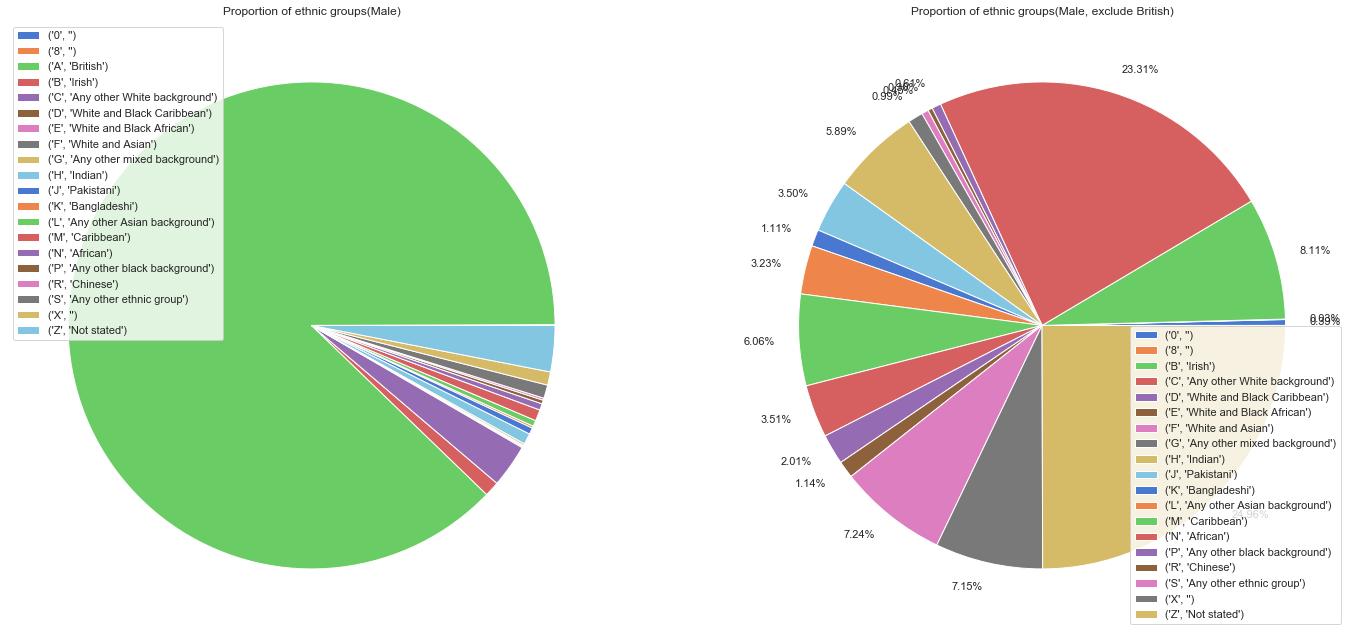

In [102]:
# Visualise the proportion in two pie charts
fig1, ax1 = plt.subplots(1, 2, figsize=(24, 24))
ax1[0].pie(m_ethnicity, textprops={'fontsize': 8})
ax1[1].pie(m_non_british, labels=['%.2f%%' % (x / m_non_british.sum() * 100) for x in m_non_british.values])
ax1[0].set_title('Proportion of ethnic groups(Male)')
ax1[1].set_title('Proportion of ethnic groups(Male, exclude British)')
ax1[0].legend(m_labels)
ax1[1].legend(m_non_british_labels, loc='lower right')
plt.show()


In [103]:
# The proportion of ethnic groups among female patients
fm_ethnicity = group_sex_ethnicity['PATIENTID'][20:40]
fm_ethnicity_codes = [x[1] for x in fm_ethnicity.index]
fm_labels = list(zip(fm_ethnicity_codes, ethnicity_names))

# The proportion of ethnic groups among non-british female patients
fm_non_british = fm_ethnicity.drop(labels=(2, 'A'))
fm_non_british_labels = list(zip(fm_ethnicity_codes, ethnicity_names))
fm_non_british_labels.remove(('A', 'British'))

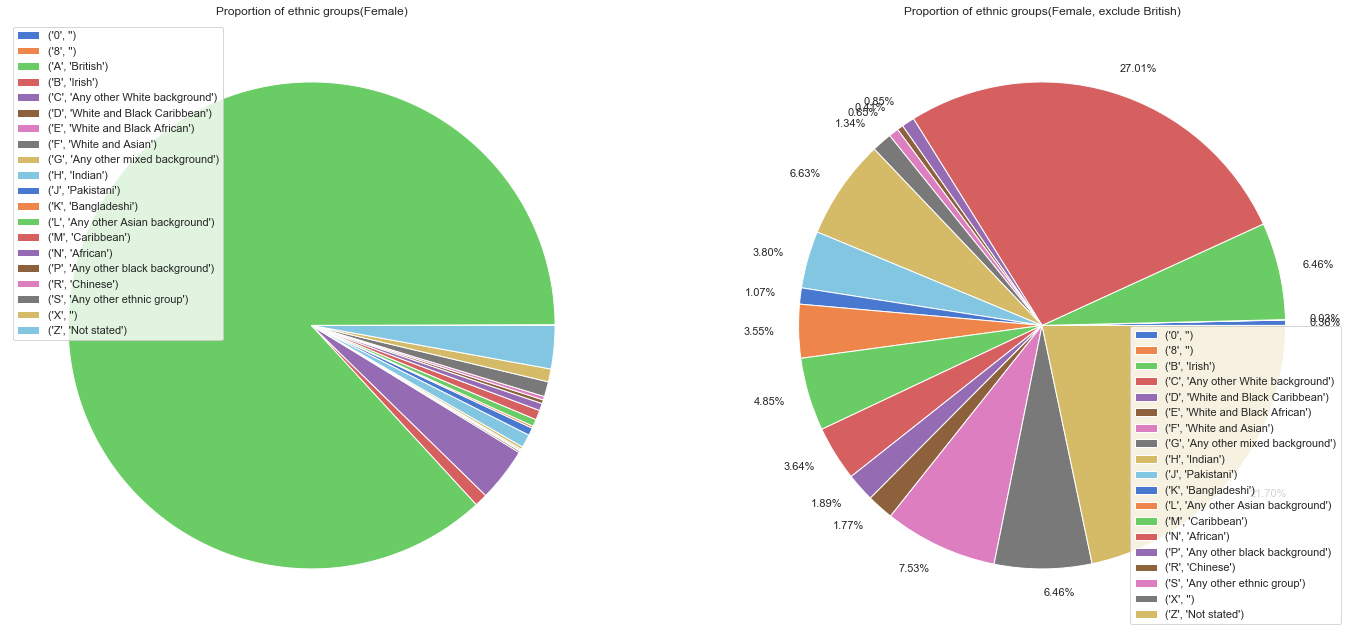

In [104]:
# Visualise the proportion in two pie charts
fig2, ax2 = plt.subplots(1, 2, figsize=(24, 24))
ax2[0].pie(fm_ethnicity)
ax2[1].pie(fm_non_british, labels=['%.2f%%' % (x / fm_non_british.sum() * 100) for x in fm_non_british.values])
ax2[0].set_title('Proportion of ethnic groups(Female)')
ax2[1].set_title('Proportion of ethnic groups(Female, exclude British)')
ax2[0].legend(fm_labels)
ax2[1].legend(fm_non_british_labels)
plt.show()

##### II. Age Distribution

Ages of the patients vary from zero to 105 years old. The average age is 66.18 and the median is 69.

In [105]:
print('The most elder: ' + str(merged_av_data['AGE'].max()))
print('The most young: ' + str(merged_av_data['AGE'].min()))
print('The mean: ' + str('%.2f' % merged_av_data['AGE'].mean()))
print('The median: ' + str(merged_av_data['AGE'].median()))

The most elder: 105
The most young: 0
The mean: 66.18
The median: 69.0


The two diagrams below illustrate the distribution of ages of patients and the death rates of each age group (divided by 10 years).

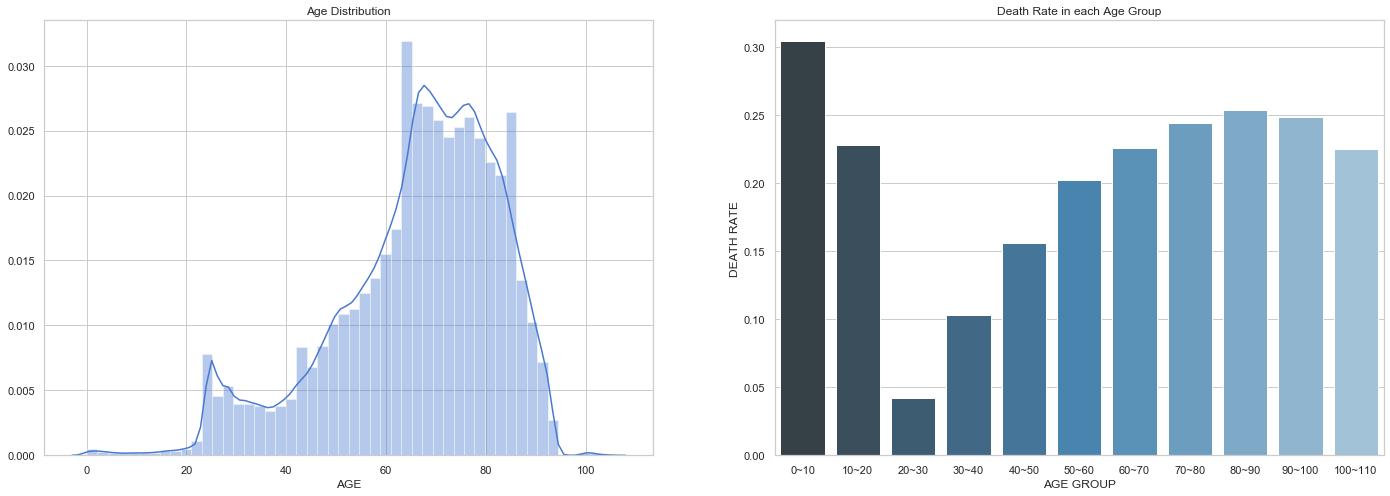

In [106]:
# Set a matplotlib figure for a new plot.
f, axes = plt.subplots(1, 2, figsize=(24, 8), dpi=72)
age_distribution = sns.distplot(merged_av_data['AGE'], ax=axes[0]) # Plot a histogram to show the distribution of age groups
age_distribution.set_title('Age Distribution') # Set title for the group

def calculate_death_rate(group):
    """
    This function calculates the death rate in the given group of ages.
    :param group: list
    :return: float
    """
    g = merged_av_data.loc[(merged_av_data['AGE'] > group[0]) & (merged_av_data['AGE'] <= group[1]), :].groupby('NEWVITALSTATUS').count()
    death_rate = g.iloc[g.index.get_level_values('NEWVITALSTATUS') == 'D'].sum().max() / merged_av_data.loc[(merged_av_data['AGE'] > group[0]) & (merged_av_data['AGE'] <= group[1]), :].shape[0]
    return death_rate

age_groups = np.array([[x*10, (x+1)*10] for x in range(11)]) # Divide patients into 10 age groups.

death_rate_by_age_group = pd.DataFrame(data={'AGE GROUP': [str(group[0]) + '~' + str(group[1]) for group in age_groups], 'DEATH RATE': [calculate_death_rate(group) for group in age_groups]})

# Plot a bar chart to illustrate the death rates in each group.
ax_death_by_age = sns.barplot(x='AGE GROUP', y='DEATH RATE', data=death_rate_by_age_group, palette='Blues_d', orient='H', ax=axes[1])
ax_death_by_age.set_title('Death Rate in each Age Group')
plt.xlabel = [x for x in range(10)]

The diagram of age distribution reveals that risk of getting cancer keeps growing after 40 and reach its peek in 70s. Early 20s marks a crest before 40. However, people who are 20-30 years old faced the minimum threats of death while children in 0-10 are the most likely to die of cancers.

#### 2.6.2 Classification of neoplasms and death rates

##### I. Classify neoplasms by site

The `SIM_AV_TUMOUR` table recorded sites of the tumours with 4-digit and 3-digit ICD-10 codes. The following codes match 3-digit ICD-10 codes representing the site of each tumour with the description of it from `icd_codes_3char.csv` and calculate death rates of different neoplasms.

A new dataframe containing`Code`, `Description`, `Amount` and `Death Rate` can be seen in the following part.

In [107]:
def match_neoplasms_3CHAR(site_code_3CHAR):
    """
    This function matches the given 3-digit code with description of a certain type of neoplasms according to ICD-10 codes.
    :param site_code_3CHAR: string
    :return: string
    """
    if site_code_3CHAR != "":
        return icd_codes_3char.loc[icd_codes_3char['Code'] == [re.search(site_code_3CHAR, icd_code).string for icd_code in icd_codes_3char['Code'].values if re.search(site_code_3CHAR, icd_code) != None][0], 'Description'].values[0]
    
def death_rate_by_site_3CHAR(site_code_3CHAR):
    """
    This function calculates the death rate of the given neoplasm.
    :param site_code_3CHAR: string
    :return: float
    """
    if site_code_3CHAR != "":
        g = merged_av_data[merged_av_data['SITE_ICD10_O2_3CHAR'] == site_code_3CHAR].groupby('NEWVITALSTATUS').count()
        death_rate = g.iloc[g.index.get_level_values('NEWVITALSTATUS') == 'D'].sum().max() / g.iloc[:, :].sum().max()
        return death_rate

types_of_cancer_3CHAR = pd.DataFrame({
    'Code': merged_av_data['SITE_ICD10_O2_3CHAR'].value_counts().index,
    'Description': [match_neoplasms_3CHAR(x) for x in list(merged_av_data['SITE_ICD10_O2_3CHAR'].value_counts().index.to_numpy())],
    'Amount': merged_av_data['SITE_ICD10_O2_3CHAR'].value_counts().values,
    'Death Rate': [death_rate_by_site_3CHAR(x) for x in list(merged_av_data['SITE_ICD10_O2_3CHAR'].value_counts().index.to_numpy())]
})

It can be seen from the briefing of the dataframe that, the least deadly tumours are:
- Carcinoma in situ of cervix uteri 
- Carcinoma in situ of breast
- Malignant neoplasm of testis
- Carcinoma in situ of other and unspecified genital organs
- Melanoma in situ

These tumours feature low death rate - less than **5%** in general but high incidence.

In [108]:
types_of_cancer_3CHAR.sort_values('Code').sort_values('Death Rate', ascending=True).head()

,Code,Description,Amount,Death Rate
4,D06,Carcinoma in situ of cervix uteri,76678,0.001500
14,D05,Carcinoma in situ of breast,19777,0.013905
36,C62,Malignant neoplasm of testis,5807,0.015499
29,D07,Carcinoma in situ of other and unspecified gen...,6931,0.025393
16,D03,Melanoma in situ,17123,0.029142


While the most deadly tumours are:
- Malignant neoplasm without specification of site
- Malignant neoplasm of other and ill-defined digestive organs
- Malignant neoplasm of pancreas
- Secondary malignant neoplasm of respiratory and digestive organs
- Malignant neoplasm of gallbladder

These malignant tumours cause extremely high rates of death, which are all over **70%**.

In [109]:
types_of_cancer_3CHAR.sort_values('Code').sort_values('Death Rate', ascending=True).tail(6)

,Code,Description,Amount,Death Rate
55,C23,Malignant neoplasm of gallbladder,2120,0.713208
41,C78,Secondary malignant neoplasm of respiratory an...,4467,0.734721
12,C25,Malignant neoplasm of pancreas,21344,0.761666
75,C26,Malignant neoplasm of other and ill-defined di...,756,0.767196
26,C80,Malignant neoplasm without specification of site,8657,0.808017
91,,None,461,NaN


The comparision reveals that, despite of high incidence, carcinoma in-situ of genital organs is the least fatal. On the contrary, malignant neoplasms of digestive organs result in the most deaths.

The following codes group the tumours in this list into two types 'C' and 'D', namely the maligant and benign tumours with a scatter plot to show the death rates and incidence of each kind of tumours. Benign tumours orange in colour while malignant neoplasms are blue in this plot.

In [110]:
# Add a column to separate the tumours into two types 'C' and 'D', namely malignant and benign tumours.
types_of_cancer_3CHAR.insert(column='Type', value=[x[0][0] if x[0] != '' else '' for x in types_of_cancer_3CHAR.values], loc=4)

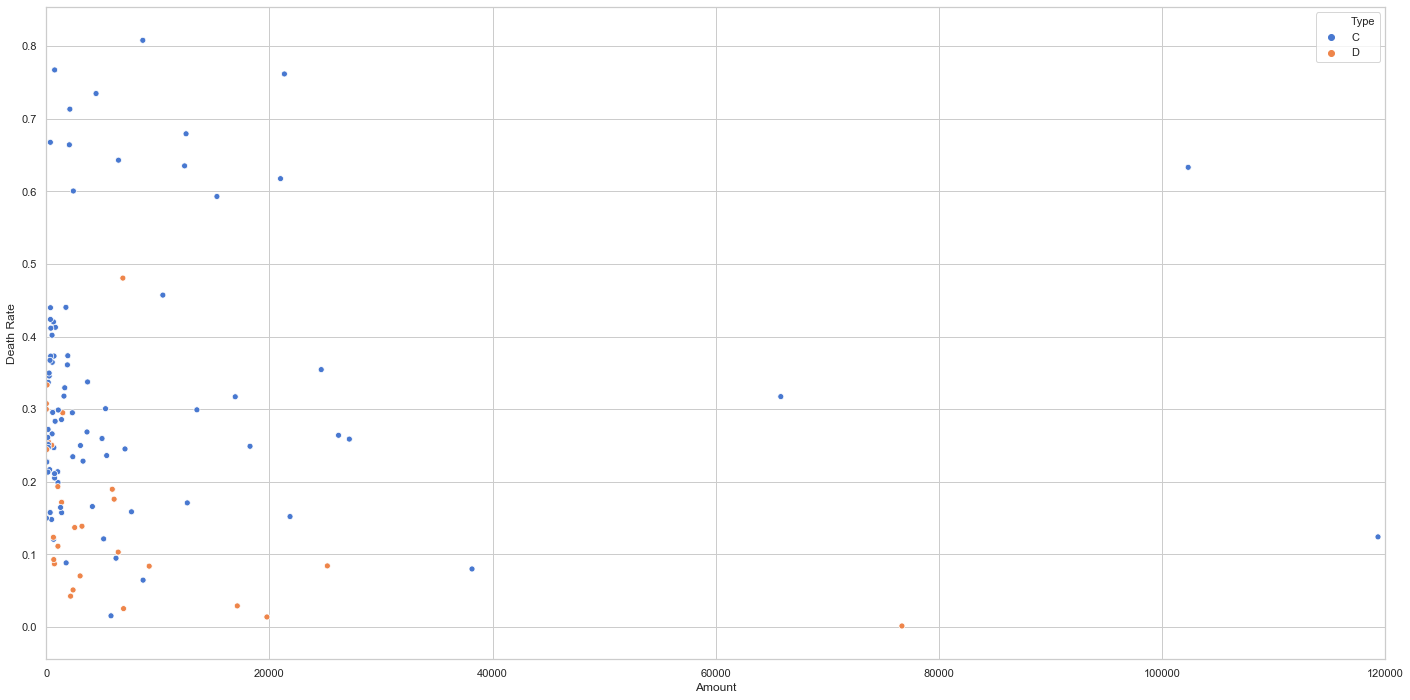

In [111]:
# Initiate a new matplotlib figure
f0, axes0 = plt.subplots(1, 1, figsize=(24, 12), dpi=72)
sns.scatterplot(data=types_of_cancer_3CHAR, x='Amount', y='Death Rate', hue='Type', ax=axes0)
plt.xlim(xmax = 120000, xmin = 0)
plt.show()

It can be seen from the plot that most benign tumours have a low rate of death which is lower than 50%.



The following diagram shows mortality rates of each kind of tumours (classified by its site) in descending order. 

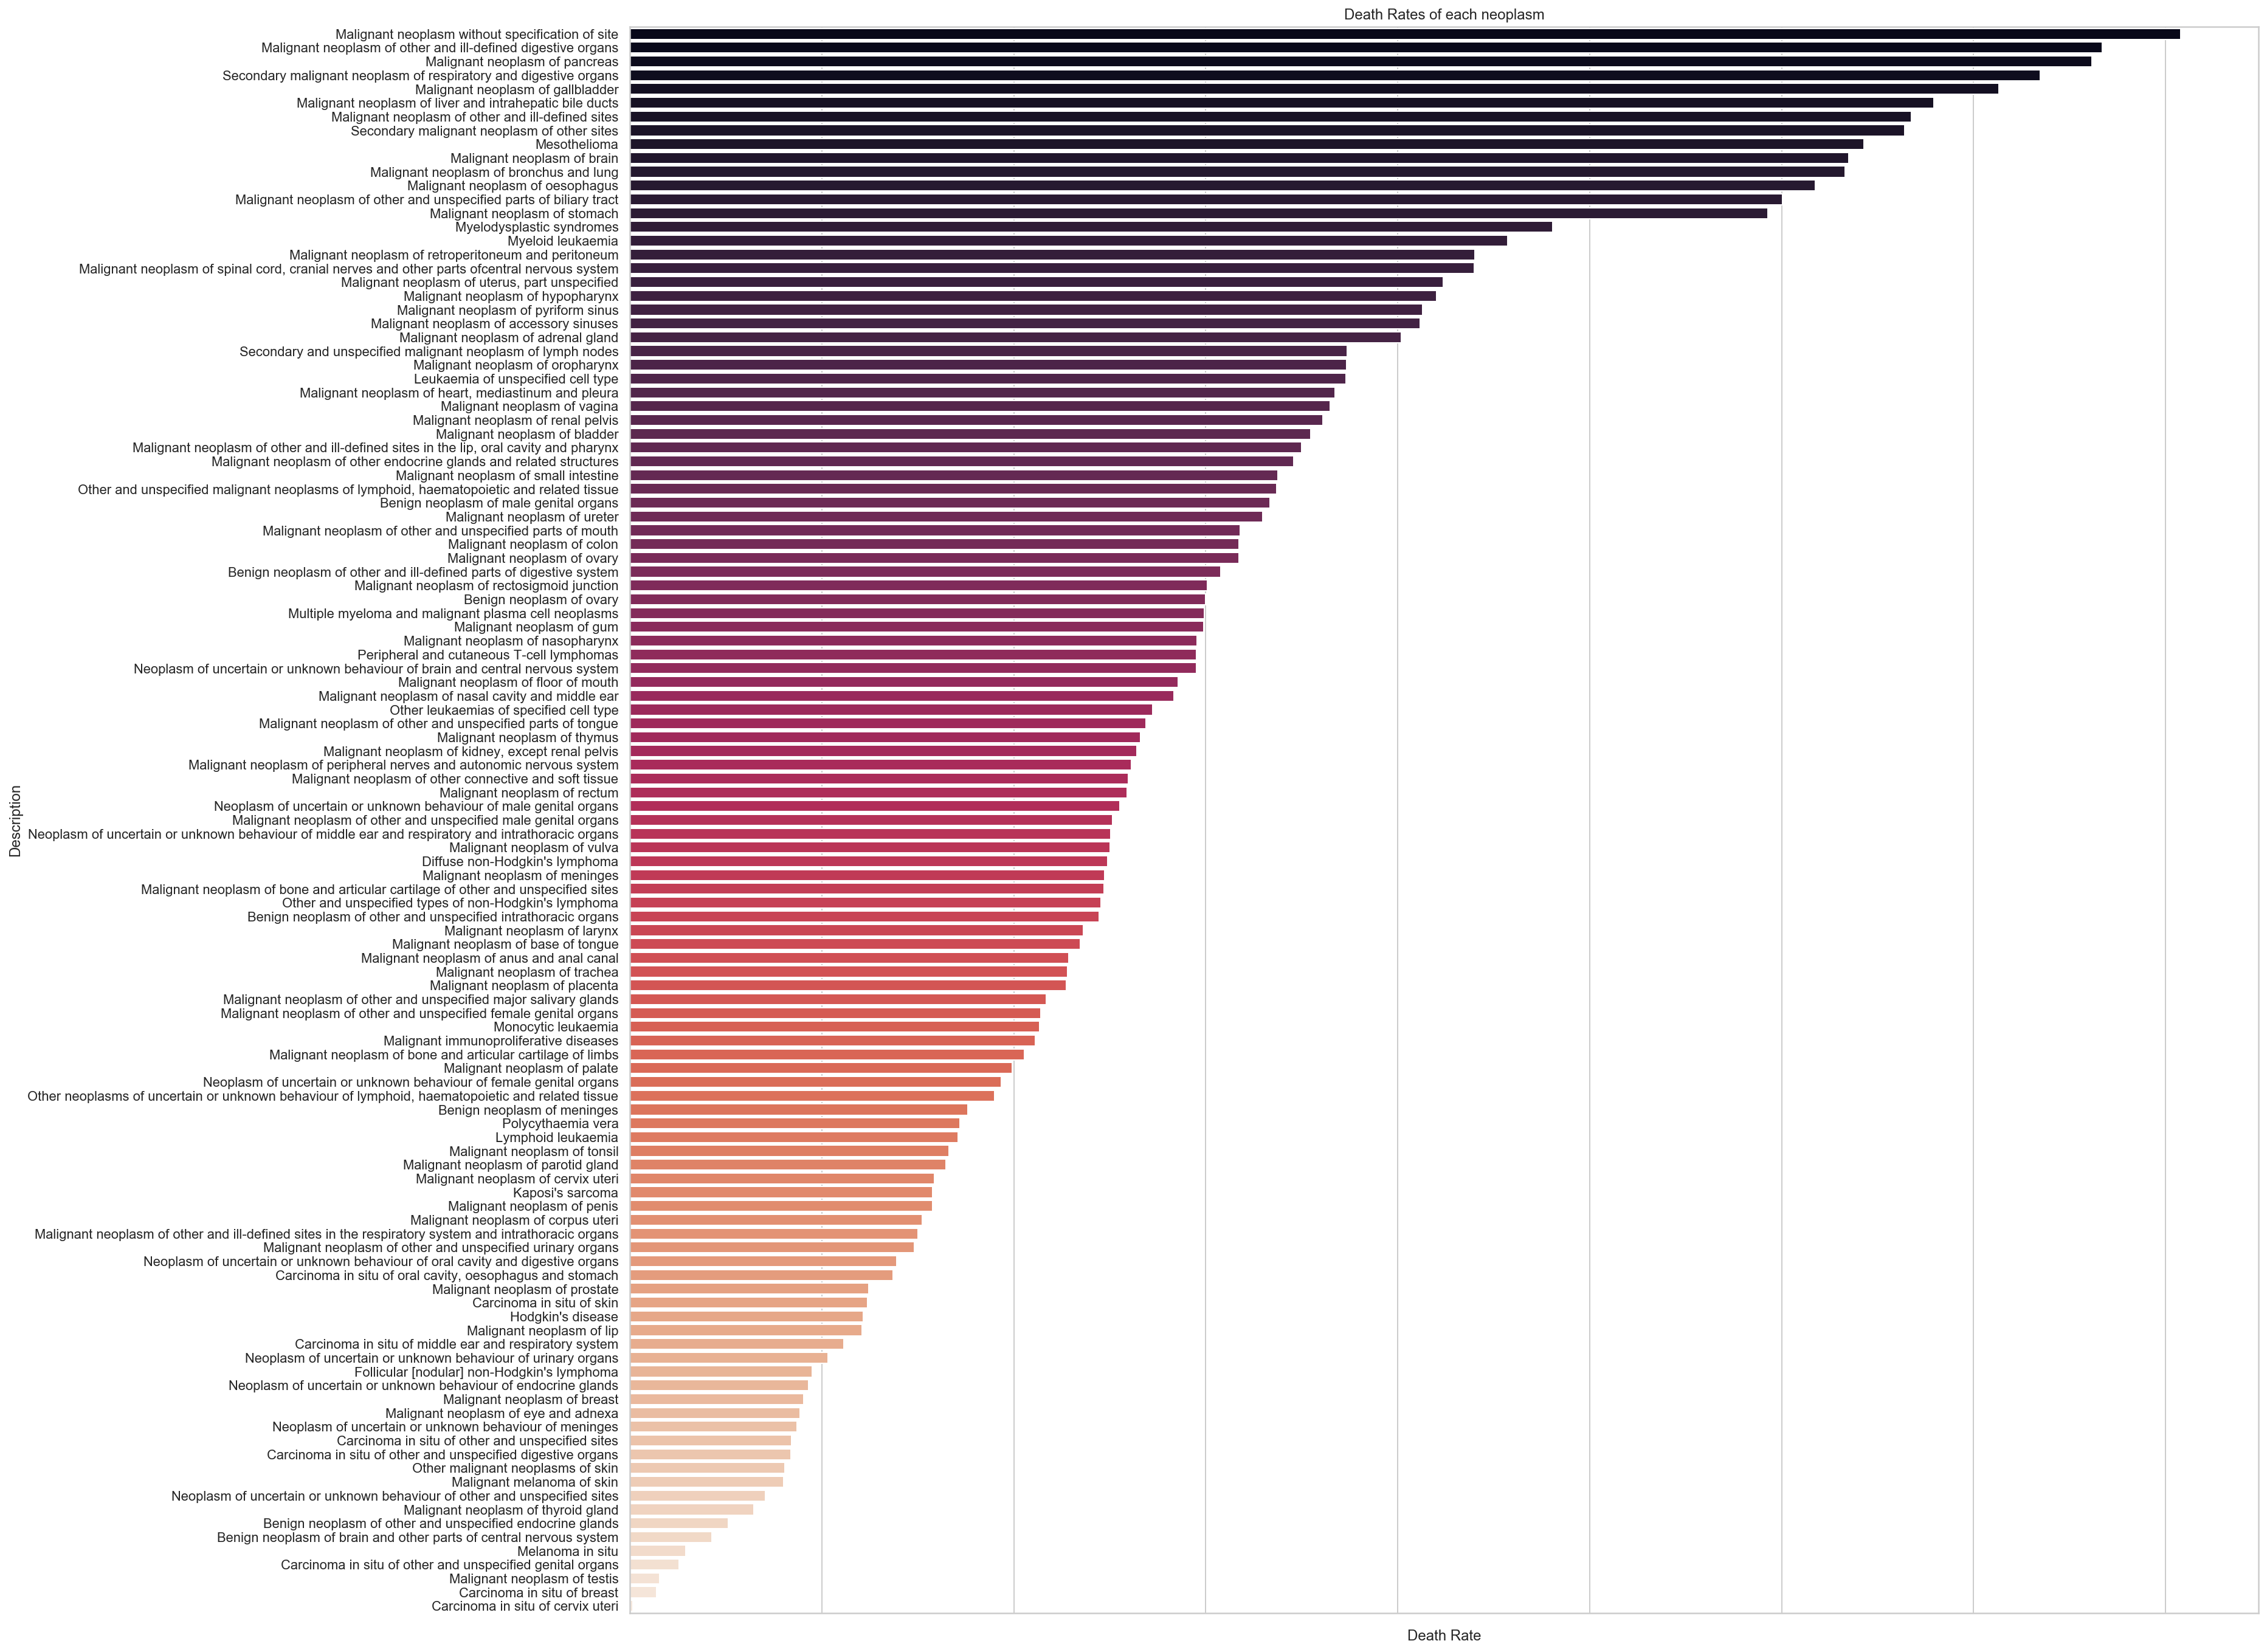

In [58]:
# Display death rates of each type of neoplasms in a barplot.
f1, axes1 = plt.subplots(1, 1, figsize=(24, 24), dpi=144)
types_of_neoplasms = sns.barplot(data=types_of_cancer_3CHAR.sort_values('Death Rate', ascending=False), x='Death Rate', y='Description', ax=axes1, palette='rocket')
axes1.set_xticklabels(axes1.get_xticklabels(), rotation=90) # Rotate the labels to make them clear.
types_of_neoplasms.set_title('Death Rates of each neoplasm') # Set title for this diagram.
plt.show()

##### II. Compare incidence of tumours in different genders

The incidence of tumours among the male and the female can be different. The codes below calculate the numbers of neoplasms in both sex groups. The result is in the form of two new columns and appended to the original `types_of_cancer_3CHAR` dataframe.


In [113]:
def calculate_site_by_sex(site_code_3CHAR):
    """
    This function calculates the amounts of the given tumour in both sex groups.
    :param site_code_3CHAR: string
    :return: float
    """
    if type(site_code_3CHAR) == str and site_code_3CHAR != '':
        site_in_male = merged_av_data[(merged_av_data['SITE_ICD10_O2_3CHAR'] == site_code_3CHAR) & (merged_av_data['SEX_x'] == 1)].shape[0]
        site_in_female = merged_av_data[(merged_av_data['SITE_ICD10_O2_3CHAR'] == site_code_3CHAR) & (merged_av_data['SEX_x'] == 2)].shape[0]
        return [site_in_male, site_in_female]
    else:
        return [0, 0]

# Join the amounts of tumours in both sex groups with the original dataframe
amount_by_sex = pd.DataFrame({
    'Male': [x[0] for x in types_of_cancer_3CHAR['Code'].map(calculate_site_by_sex).values],
    'Female': [x[1] for x in types_of_cancer_3CHAR['Code'].map(calculate_site_by_sex).values]})

types_of_cancer_3CHAR = types_of_cancer_3CHAR.join(amount_by_sex)

The diagram below contains two bar charts sharing the y-axis. The y-axis indicates the classification of tumours in a descending order of death rate. The diagram shows **incidence** of tumours among the male (on the left) and the female (on the right).

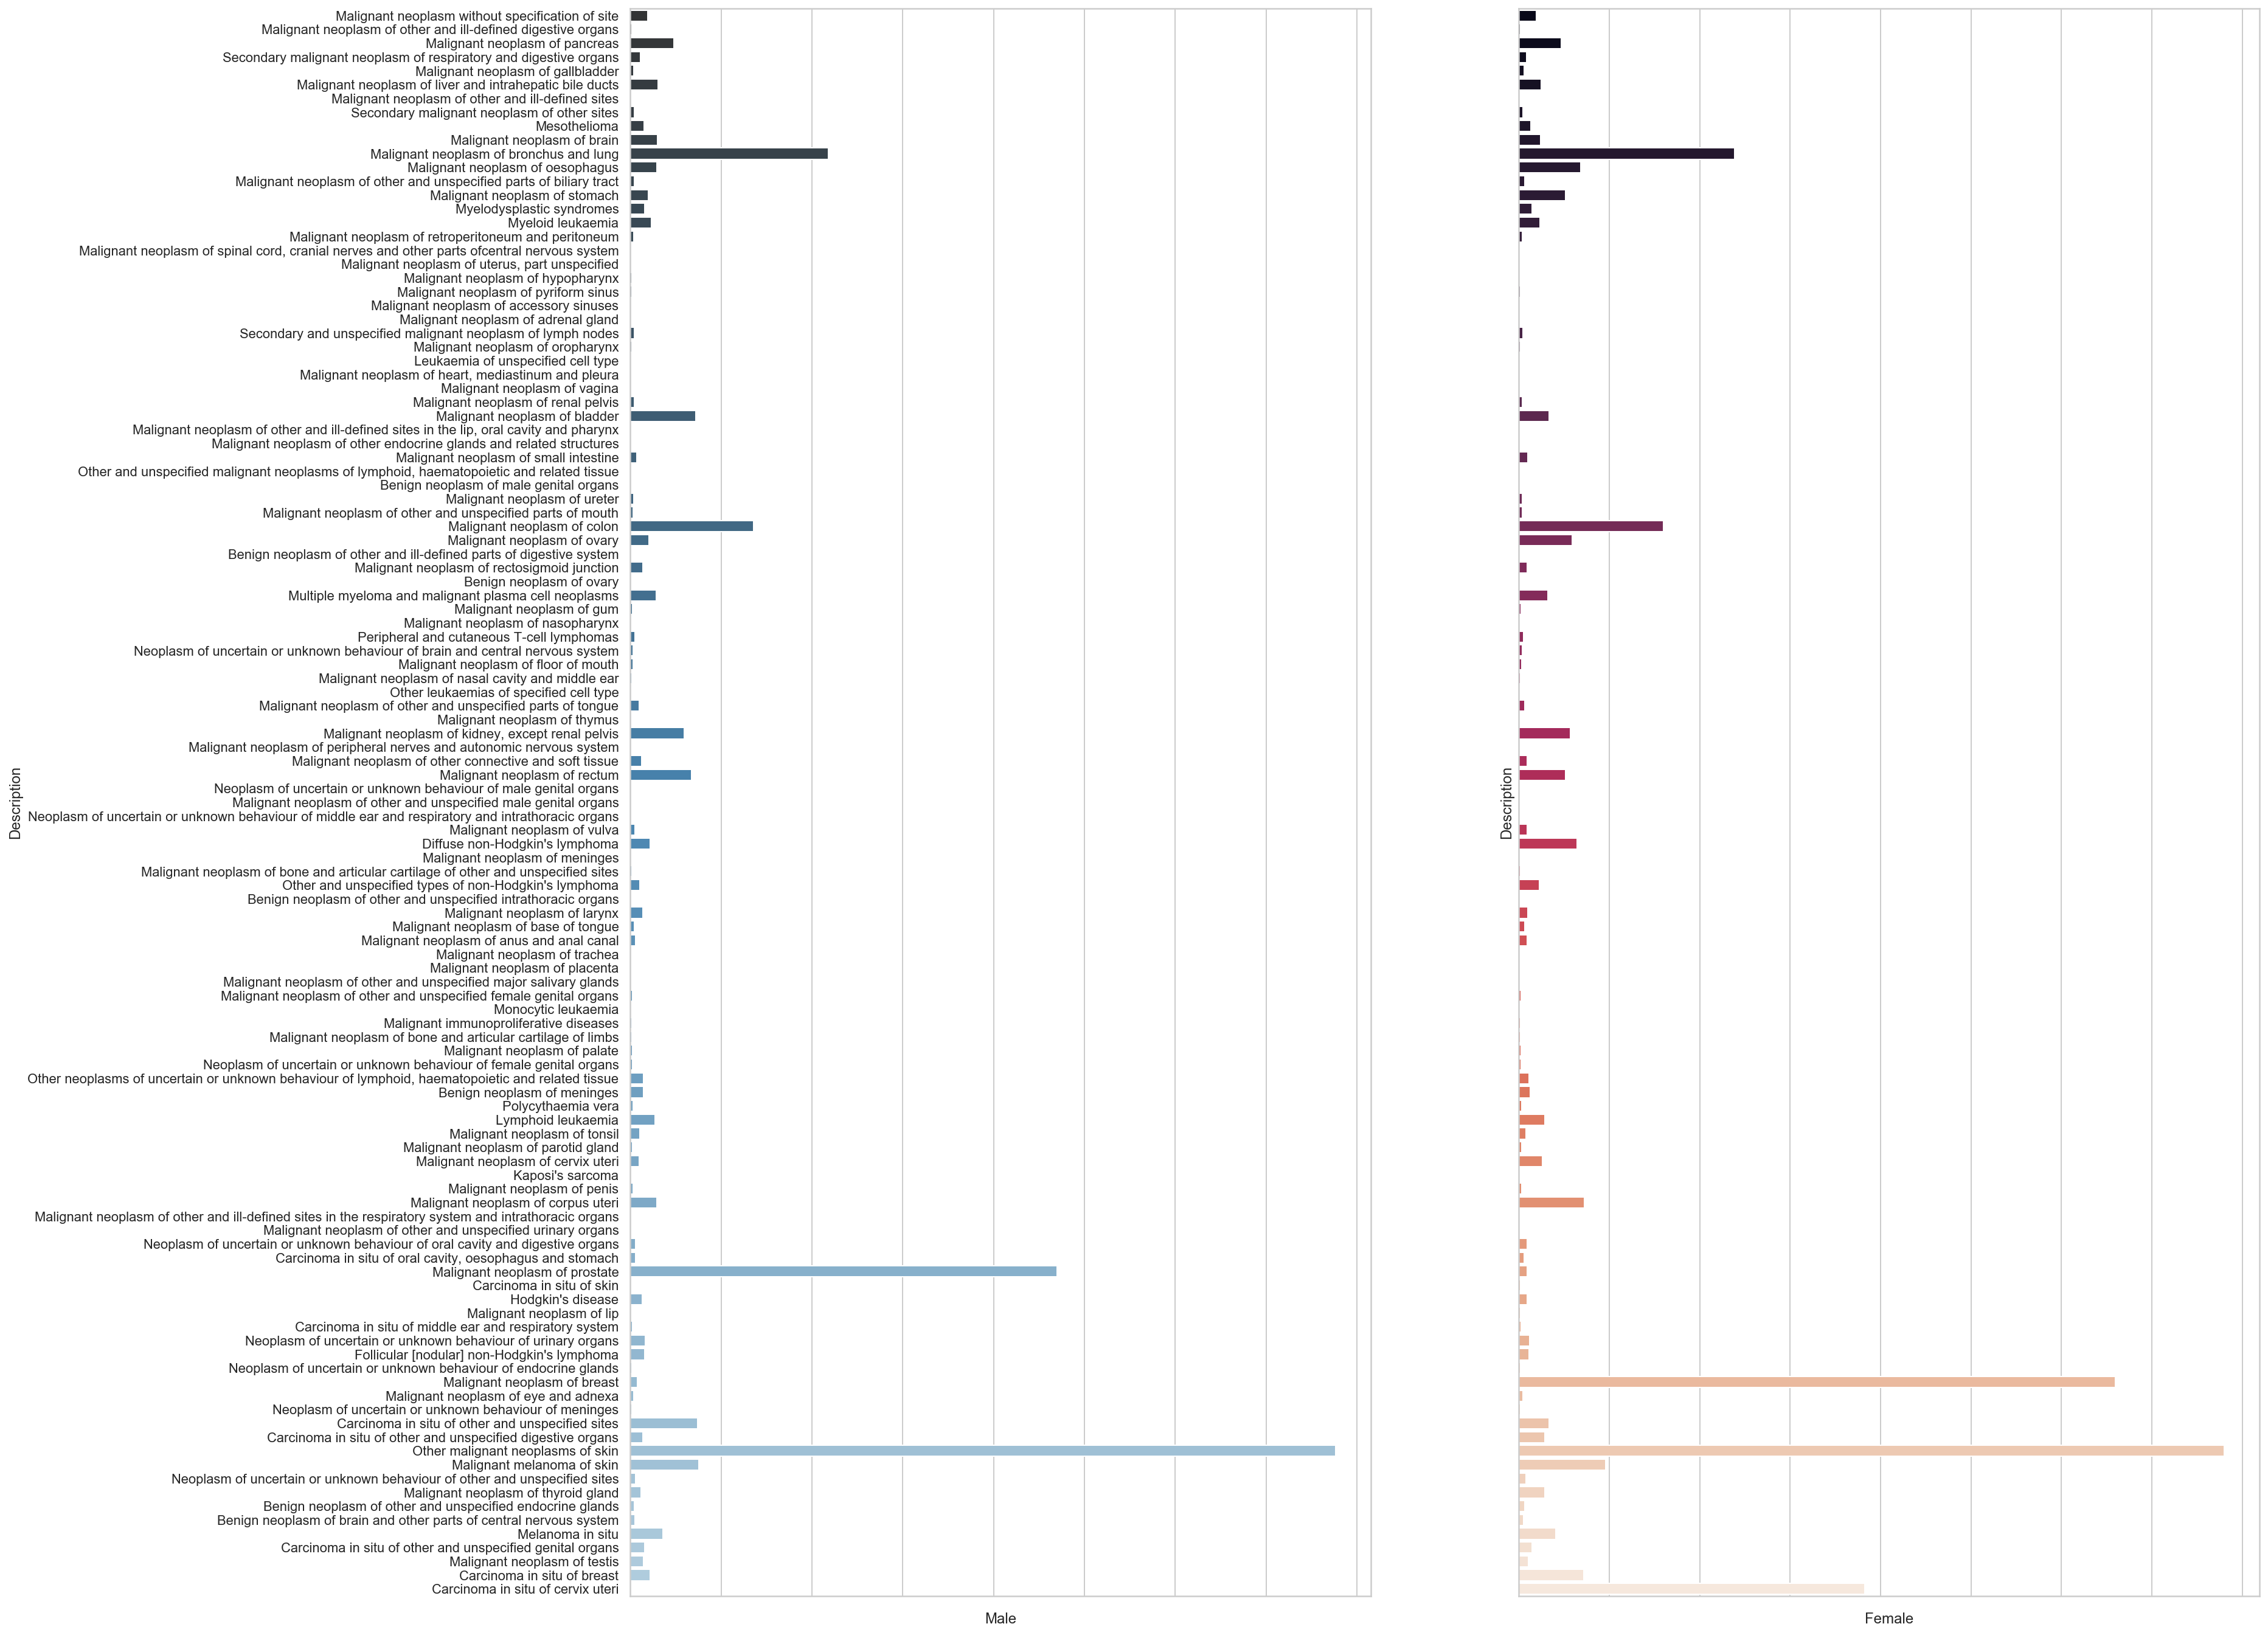

In [114]:
f2, axes2 = plt.subplots(1, 2, figsize=(24, 24), dpi=144, sharey=True)
types_of_neoplasms_by_sex = sns.barplot(data=types_of_cancer_3CHAR.sort_values('Death Rate', ascending=False), x='Male', y='Description', ax=axes2[0], palette='Blues_d')
types_of_neoplasms_by_sex = sns.barplot(data=types_of_cancer_3CHAR.sort_values('Death Rate', ascending=False), x='Female', y='Description', ax=axes2[1], palette='rocket')
axes2[0].set_xticklabels(axes2[0].get_xticklabels(), rotation=90)
axes2[1].set_xticklabels(axes2[1].get_xticklabels(), rotation=90)
plt.show()

#### 2.6.3 TNM Staging and death rates

Another important information in this table is the TNM staging of tumours. The TNM Classification of Malignant Tumors (TNM) is a globally recognised standard for classifying the extent of spread of cancer. The three letters stand for:

**T**: size or direct extent of the primary tumor

**N**: degree of spread to regional lymph nodes

**M**: presence of distant metastasis

And in each class, there are also mandatory parametres which can better describe the stage of almost all the cancers.

| T | N | M |
|-----| ----|----|
| **Tx** (tumor cannot be assessed) | **Nx** (lymph nodes cannot be assessed) | **M0** (no distant metastasis) |
| **Tis** (carcinoma in situ) | **N0** (no regional lymph nodes metastasis) | **M1** (metastasis to distant organs (beyond regional lymph nodes) |
| **T0** (no evidence of tumor) | **N1** (regional lymph node metastasis present; at some sites, tumor spread to closest or small number of regional lymph nodes) | |
| **T1, T2, T3, T4** (size and/or extension of the primary tumor) | **N2** (tumor spread to an extent between N1 and N3 (N2 is not used at all sites) | |
| | **N3** (tumor spread to more distant or numerous regional lymph nodes (N3 is not used at all sites)) | |

Staging tumours is also helpful to have an idea about a patient's chance of survival. In general, distant metastasis means that the tumour is very hard to be cure and the patient faces great risks of death.

Records in this dataset included some more detailed classification, such as **'T1a2'**. The following codes will turn all the entries into a general classification just as in the table above so as to conduct an analysis on tumours in different stages.

In [61]:
def clean_stages(stage):
    """
    This function returns the stage of the tumours in 2-digit TNM code by identifying the first digit in the record.
    :param stage: string
    :return: string
    """
    if stage == 'X' or stage == '' or stage == 'is':
        return stage
    else:
        for i in stage:
            if i.isdigit():
                return i
    
# Map this funciton to all the three stages columns.
merged_av_data['T_BEST'] = merged_av_data['T_BEST'].map(str).map(clean_stages)
merged_av_data['N_BEST'] = merged_av_data['N_BEST'].map(str).map(clean_stages)
merged_av_data['M_BEST'] = merged_av_data['M_BEST'].map(str).map(clean_stages)

The codes below divided the patients into three groups:
1. `primary_tumour`: only diagnosed to have primary tumour without spread to lymph nodes and distant metastasis.

In [63]:
# Primary Tumour, namely T1, T2, T3 and T4, but not spread to regional lymph nodes or have distant metastasis
primary_tumour = merged_av_data[(merged_av_data['T_BEST'].map(lambda x: True if x in ['1', '2', '3', '4'] else False)) & (merged_av_data['N_BEST'] == '0') & (merged_av_data['M_BEST'] == '0')].groupby('NEWVITALSTATUS').count()
death_rate_primary_tumour = primary_tumour.iloc[primary_tumour.index.get_level_values('NEWVITALSTATUS') == 'D'].max()[0] / primary_tumour.sum()[0]
# "{:.2f}".format(death_rate_primary_tumour)

# Spread to regional lymph nodes, namely N1, N2, N3, N4 but no distant metastasis
lymph_spread = merged_av_data[(merged_av_data['N_BEST'].map(lambda x: True if x in ['1', '2', '3', '4'] else False)) & (merged_av_data['M_BEST'] == '0')].groupby('NEWVITALSTATUS').count()
death_rate_lymph_spread = lymph_spread.iloc[lymph_spread.index.get_level_values('NEWVITALSTATUS') == 'D'].max()[0] / lymph_spread.sum()[0]
# "{:.2f}".format(death_rate_lymph_spread)

# Distant Metastasis, namely M1 and M2
metastasis_true = merged_av_data[(merged_av_data['M_BEST'] == '1') | (merged_av_data['M_BEST'] == '2')].groupby('NEWVITALSTATUS').count()
death_rate_metastasis_true = metastasis_true.iloc[metastasis_true.index.get_level_values('NEWVITALSTATUS') == 'D'].max()[0] / metastasis_true.sum()[0]
# "{:.2f}".format(death_rate_metastasis_true)

In [121]:
print('Primary tumour without spread and distant metastasis: ' + str(primary_tumour.sum().max()) + '.')
print('Tumour spread to regional lymph nodes: ' + str(lymph_spread.sum().max()) + '.')
print('Tumour had distant metastasis: ' + str(metastasis_true.sum().max()) + '.')


Primary tumour without spread and distant metastasis: 263485.
Tumour spread to regional lymph nodes: 109505.
Tumour had distant metastasis: 132347.


In [64]:
merged_av_data[(merged_av_data['M_BEST'] == '1') | (merged_av_data['M_BEST'] == '2')].groupby('SITE_ICD10_O2_3CHAR').count().sort_values('DIAGNOSISDATEBEST', ascending=False).head()

,DIAGNOSISDATEBEST,SITE_ICD10_O2,MORPH_ICD10_O2,BEHAVIOUR_ICD10_O2,T_BEST,N_BEST,M_BEST,STAGE_BEST,STAGE_BEST_SYSTEM,GRADE,...,LINKNUMBER_y,ETHNICITY,DEATHCAUSECODE_1A,DEATHCAUSECODE_1B,DEATHCAUSECODE_1C,DEATHCAUSECODE_2,DEATHCAUSECODE_UNDERLYING,DEATHLOCATIONCODE,NEWVITALSTATUS,VITALSTATUSDATE
SITE_ICD10_O2_3CHAR,,,,,,,,,,,,,,,,,,,,,
C34,46060,46059,46051,46053,37603,38819,46060,46060,40341,45837,...,46060,44806,34881,9618,1251,14270,34533,34888,46060,46060
C61,15482,15482,15475,15482,8825,6984,15482,15482,13016,15448,...,15482,14914,2112,697,125,1201,2105,2111,15482,15482
C18,14861,14853,14856,14855,8990,9142,14861,14861,12741,14792,...,14861,14509,5935,1803,417,2362,5879,5935,14861,14861
C25,9274,9274,9265,9271,3417,3511,9274,9274,7564,9226,...,9274,8965,8039,1596,273,2402,7918,8040,9274,9274
C50,6275,6273,6272,6273,3544,3402,6275,6275,4148,6229,...,6275,6115,724,229,35,345,721,724,6275,6275


No handles with labels found to put in legend.


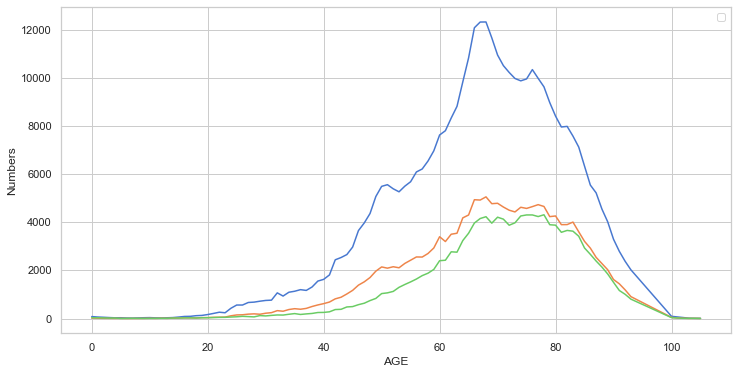

In [65]:
t_dist = merged_av_data[(merged_av_data['T_BEST'] == '1') | (merged_av_data['T_BEST'] == '2')].groupby('AGE').count()['DIAGNOSISDATEBEST']
n_dist = merged_av_data[(merged_av_data['N_BEST'] == '1') | (merged_av_data['N_BEST'] == '2')].groupby('AGE').count()['DIAGNOSISDATEBEST']
m_dist = merged_av_data[(merged_av_data['M_BEST'] == '1') | (merged_av_data['M_BEST'] == '2')].groupby('AGE').count()['DIAGNOSISDATEBEST']

f3, axes3 = plt.subplots(1, 1, figsize=(12, 6), dpi=72)
t_dist_plot = sns.lineplot(x=merged_av_data.groupby('AGE').count().index, y=t_dist, ax=axes3)
n_dist_plot = sns.lineplot(x=merged_av_data.groupby('AGE').count().index, y=n_dist, ax=axes3)
m_dist_plot = sns.lineplot(x=merged_av_data.groupby('AGE').count().index, y=m_dist, ax=axes3)
m_dist_plot.set_ylabel('Numbers')
m_dist_plot.set_ylabel('Numbers')
# plt.show()
axes3.legend()

# types_of_neoplasms_by_sex = sns.barplot(data=types_of_cancer_3CHAR.sort_values('Death Rate', ascending=False), x='Male', y='Description', ax=axes2[0], palette='Blues_d')
# types_of_neoplasms_by_sex = sns.barplot(data=types_of_cancer_3CHAR.sort_values('Death Rate', ascending=False), x='Female', y='Description', ax=axes2[1], palette='rocket', alpha=0.7)
# axes2[0].set_xticklabels(axes2[0].get_xticklabels(), rotation=90)
# axes2[1].set_xticklabels(axes2[1].get_xticklabels(), rotation=90)
# plt.show()